## Evaluate Microsoft Phi 3 LLM for answer generation

https://huggingface.co/microsoft/Phi-3-mini-4k-instruct

In [1]:
# provide project root path
#ProjectRoot = "/content/drive/MyDrive/UMich Capstone/NoteBooks/"
ProjectRoot = "/home/sangram/Tutorbot_capstone/git_hub/Tutorbot/"
DatasetRoot = ProjectRoot + "/Dataset/"

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
try:
    import bert_score
except ImportError:
    !pip install bert_score

try:
    from evaluate import load
except ImportError:
    !pip install evaluate

try:
    import rouge_score
except ImportError:
    !pip install rouge_score


In [4]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline
import pandas as pd
import json
import bert_score
import numpy as np
import re
from evaluate import load
from tqdm.notebook import tqdm

# viz
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
# load context and question train set which was created by doc2query
train_df = pd.read_csv(DatasetRoot + 'q_a_trainset.csv')

In [6]:
# loading full article from json file
with open(DatasetRoot + 'raw_knowledge.json', 'r') as f:
    raw_text_json = json.load(f)

In [7]:
raw_df = pd.DataFrame(list(raw_text_json.items()), columns=['raw_para_id', 'raw_text'])
raw_df['raw_para_id'] = raw_df['raw_para_id'].astype('int64')

In [8]:
# create dataframe of raw, summarized paragraphs and question
train_df = train_df.merge(raw_df, left_on='raw_para_id', right_on='raw_para_id', how='left')

In [9]:
# dataframe holding metrics for different Prompt styles
Prompt_style_df = pd.DataFrame(columns=['Prompt_style', 'BERTScore_Precision', 'BERTScore_Recall', 'BERTScore_F1', 'METEOR', 'Rouge1', 'Rouge2', 'RougeL', 'RougeLsum'])

### Helper Methods

In [10]:
# LLM inference wrapper
def AskLLM(context, question, prompt_style):
    
    if prompt_style == "zero_shot":
        prompt = generate_prompt_zeroshot(context, question)
    elif prompt_style == "few_shot":
        prompt = generate_prompt_fewshot(context, question)
    elif prompt_style == "chain_of_thought":
        prompt = generate_prompt_cot(context, question)
    else:
        raise Exception("prompt style not implemented!!")

    messages = [
    {"role": "user", "content": prompt}]

    generation_args = {
        "max_new_tokens": 500,
        "return_full_text": False,
        "do_sample": False,
    }

    output = phi3_pipeline(messages, **generation_args)
    text = output[0]['generated_text']

    # Regular expression to extract the Final Answer
    if prompt_style == "zero_shot":
        answer_pattern = r"(.*)"
    else:
        answer_pattern = r"\*\*Final Answer:\*\*\s*(.*)"

    # Extract answer from LLM response
    match = re.search(answer_pattern, text, re.DOTALL)
    final_answer = "I don't know"
    if match:
        final_answer = match.group(1).strip()
    else:
        print("Final Answer not found !!!")
        print("Final Answer:", text)

    return final_answer

In [11]:
def calculate_metrics(metrics_df, prompt_style, candidate_answers, true_answers):
    # Calculate BERTScore
    # bert_metrics = bert_score.score(cands=candidate_answers, refs=true_answers, model_type='roberta-large', nthreads=4)
    bert_metrics = bert_score.score(cands=candidate_answers, refs=true_answers, model_type='bert-base-uncased', nthreads=4)

    # Fetch precision, recall, F1 score from BERT score (https://lightning.ai/docs/torchmetrics/stable/text/bert_score.html)
    BERTScore_Precision = np.mean(np.array(bert_metrics[0]))
    BERTScore_Recall = np.mean(np.array(bert_metrics[1]))
    BERTScore_F1 =  np.mean(np.array(bert_metrics[2]))
    print(f"BERTScore Precision: {BERTScore_Precision}")
    print(f"BERTScore Recall: {BERTScore_Recall}")
    print(f"BERTScore F1 Score: {BERTScore_F1}")

    # calculate meteor via https://huggingface.co/spaces/evaluate-metric/meteor
    meteor = load('meteor')
    Meteor_score = meteor.compute(predictions=candidate_answers, references=true_answers)
    Meteor_score = Meteor_score['meteor']
    print(f"METEOR Score: {Meteor_score}")

    # calculate rouge via https://huggingface.co/spaces/evaluate-metric/rouge
    rouge = load("rouge")
    rouge_score = rouge.compute(predictions=candidate_answers, references=true_answers)
    print(f"ROUGE Score: {rouge_score}")
    Rouge1  = rouge_score['rouge1']
    Rouge2  = rouge_score['rouge2']
    RougeL  = rouge_score['rougeL']
    RougeLsum = rouge_score['rougeLsum']

    # record results
    new_row = pd.DataFrame({
        'Prompt_style': [prompt_style],
        'BERTScore_Precision': [BERTScore_Precision],
        'BERTScore_Recall': [BERTScore_Recall],
        'BERTScore_F1': [BERTScore_F1],
        'METEOR': [Meteor_score],
        'Rouge1': [Rouge1],
        'Rouge2': [Rouge2],
        'RougeL': [RougeL],
        'RougeLsum': [RougeLsum]
    })

    metrics_df = pd.concat([metrics_df, new_row], ignore_index=True)

    return metrics_df

### Evaluation

In [12]:
if torch.cuda.is_available():
    torch.set_default_device("cuda")
    print("CUDA is available!!")
else:
    raise RuntimeError("CUDA is not available!! LLM cannot run, rerun with GPU")

CUDA is available!!


In [13]:
model_name = "microsoft/Phi-3-mini-4k-instruct"
model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype="auto", trust_remote_code=True)
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)

phi3_pipeline = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
)

`flash-attention` package not found, consider installing for better performance: No module named 'flash_attn'.
Current `flash-attention` does not support `window_size`. Either upgrade or use `attn_implementation='eager'`.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


#### Prompt Engineering

In [14]:
def generate_prompt_fewshot(context, question):
    prompt_template = """
You are an expert in understanding and interpreting provided text contexts. Given a context and a question, your task is to generate an accurate and informative answer based on the provided context. Here is the structure:

1. **Context:** The detailed text or passage that contains the information needed to answer the question.
2. **Question:** A specific question that needs to be answered based on the context.

Please make sure your response is clear, concise, and directly addresses the question. If the context does not contain sufficient information to answer the question, say I don't know.

**Example:**

**Context:**
"The rainforests of the Amazon are home to a vast diversity of species, including numerous plants, animals, and insects. These forests play a crucial role in regulating the Earth's climate by absorbing carbon dioxide and releasing oxygen. However, deforestation poses a significant threat to these ecosystems, leading to loss of habitat and biodiversity."

**Question:**
"Why are the rainforests of the Amazon important for the Earth's climate?"

**Answer:**
"The rainforests of the Amazon are important for the Earth's climate because they absorb carbon dioxide and release oxygen, helping to regulate the climate."

Please follow this format for each question:

**Context:**
{context}

**Question:**
{question}

**Final Answer:**
"""
    return prompt_template.format(context=context, question=question)



In [15]:
def generate_prompt_cot(context, question):
    prompt_template = """
You are an expert in understanding and interpreting provided text contexts. Given a context and a question, your task is to generate a detailed and logical answer based on the provided context. Think through the problem step by step before giving the final answer. Here is the structure:

1. **Context:** The detailed text or passage that contains the information needed to answer the question.
2. **Question:** A specific question that needs to be answered based on the context.
3. **Step-by-Step Reasoning:** Break down the thought process into logical steps to arrive at the answer.
4. **Final Answer:** The concise answer derived from the step-by-step reasoning.

**Example:**

**Context:**
"The rainforests of the Amazon are home to a vast diversity of species, including numerous plants, animals, and insects. These forests play a crucial role in regulating the Earth's climate by absorbing carbon dioxide and releasing oxygen. However, deforestation poses a significant threat to these ecosystems, leading to loss of habitat and biodiversity."

**Question:**
"Why are the rainforests of the Amazon important for the Earth's climate?"

**Step-by-Step Reasoning:**
1. The rainforests absorb carbon dioxide from the atmosphere.
2. They release oxygen, which is essential for life on Earth.
3. The process of absorbing carbon dioxide helps to reduce the overall levels of this greenhouse gas in the atmosphere.
4. Lower levels of carbon dioxide contribute to the regulation of the Earth's climate.
5. Therefore, the rainforests play a crucial role in maintaining the balance of gases in the atmosphere.

**Final Answer:**
"The rainforests of the Amazon are important for the Earth's climate because they absorb carbon dioxide and release oxygen, helping to regulate the climate."

Please follow this format for each question:

**Context:**
{context}

**Question:**
{question}

**Step-by-Step Reasoning:**
1. 

2. 

3. 

4. 

5. 

**Final Answer:**
"""
    return prompt_template.format(context=context, question=question)


In [16]:
def generate_prompt_zeroshot(context, question):
    prompt = """
You are an expert in understanding and interpreting provided text contexts. Given a context and a question, your task is to generate an accurate and informative answer based on the provided context. Here is the structure:

**Context:**
{context}

**Question:**
{question}

**Final Answer:**
"""
    return prompt.format(context=context, question=question)

#### Calculate Different metric scores

In [17]:
prompt_styles = ["zero_shot", "few_shot", "chain_of_thought"]

for prompt_style in prompt_styles:
    candidate_answers = []
    true_answers = []

    for _, eval_data in tqdm(train_df.iterrows()):
        context = eval_data.raw_text
        question = eval_data.question

        true_answers.append(eval_data.Final_answer)
        candidate_answers.append(AskLLM(context, question, prompt_style))
        
    Prompt_style_df = calculate_metrics(metrics_df = Prompt_style_df, prompt_style = prompt_style, candidate_answers = candidate_answers, true_answers = true_answers)
        
        


0it [00:00, ?it/s]

The `seen_tokens` attribute is deprecated and will be removed in v4.41. Use the `cache_position` model input instead.
You are not running the flash-attention implementation, expect numerical differences.
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


BERTScore Precision: 0.5317285656929016
BERTScore Recall: 0.7389559745788574
BERTScore F1 Score: 0.6100518703460693


[nltk_data] Downloading package wordnet to /home/sangram/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/sangram/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/sangram/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


METEOR Score: 0.42340774794370867
ROUGE Score: {'rouge1': 0.3252424381809723, 'rouge2': 0.1963731811707427, 'rougeL': 0.2743223972128104, 'rougeLsum': 0.2752746439776585}


0it [00:00, ?it/s]

Final Answer not found !!!
Final Answer:  I don't know.
Final Answer not found !!!
Final Answer:  **Answer:**
Data science is a field that unifies statistics, data analysis, informatics, and related methods to understand and analyze actual phenomena with data. It incorporates techniques and theories from mathematics, statistics, computer science, information science, and domain knowledge. Data science is considered a "fourth paradigm" of science, which includes empirical, theoretical, computational, and data-driven approaches.
Final Answer not found !!!
Final Answer:  I'm sorry, but there seems to be a mistake in the question. The term "dcologist" does not appear in the provided context. Could you please clarify or provide the correct term?
Final Answer not found !!!
Final Answer:  For your data science job, you need to engage in various tasks such as preparing data for analysis, formulating data science problems, analyzing data, developing data-driven solutions, and presenting finding

[nltk_data] Downloading package wordnet to /home/sangram/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/sangram/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/sangram/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


METEOR Score: 0.4518982172366628
ROUGE Score: {'rouge1': 0.39051610232371914, 'rouge2': 0.2717403828089627, 'rougeL': 0.34892313863994406, 'rougeLsum': 0.34689884995908715}


0it [00:00, ?it/s]

BERTScore Precision: 0.569606363773346
BERTScore Recall: 0.7157650589942932
BERTScore F1 Score: 0.6244332194328308


[nltk_data] Downloading package wordnet to /home/sangram/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/sangram/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/sangram/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


METEOR Score: 0.4302204463673305
ROUGE Score: {'rouge1': 0.3777571269730688, 'rouge2': 0.2396801052841136, 'rougeL': 0.32754655083583306, 'rougeLsum': 0.3247054450751783}


### Visualization of different Prompt style performance

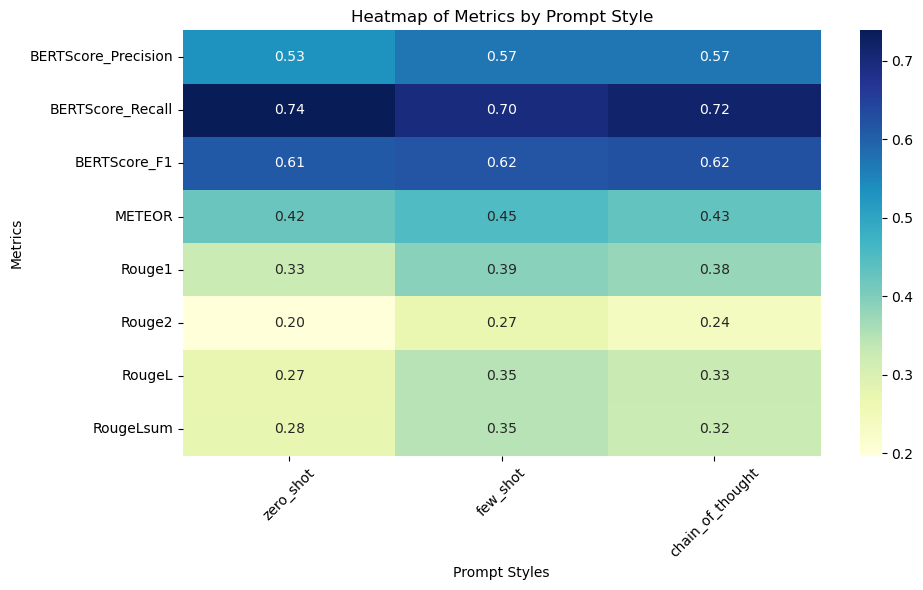

In [18]:

# pivot to have Prompt_style on x-axis
heatmap_data = Prompt_style_df.set_index('Prompt_style').T

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu', fmt='.2f')
plt.title('Heatmap of Metrics by Prompt Style')
plt.xlabel('Prompt Styles')
plt.ylabel('Metrics')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()
